In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_fscore_support,\
precision_recall_curve

from sklearn import tree
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate

import pickle
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder
import statistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer

#show warnings at each run:
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"
warnings.filterwarnings('ignore')

rs=0 #choosing a global random state value:

In [2]:
my_palette = {'#4CC9F0','#3A0CA3'} #, '#F72585', '#7209B7'}

In [3]:
original_df = pd.read_csv("restaurant_customer_satisfaction.csv") 

# Exploratory Data Analysis (EDA)

In [4]:
df = original_df.copy()

### Checking missing values

Instead of describe can use a heatmap to visualize the null values. 

<Axes: >

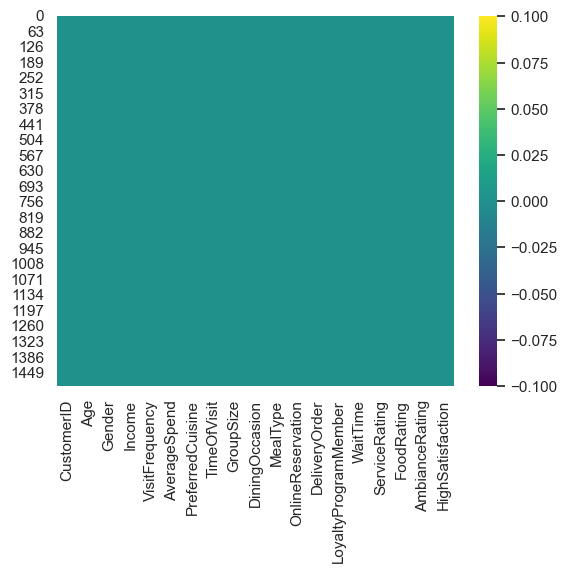

In [5]:
# df.describe()
sns.heatmap(pd.isnull(df),cmap='viridis')

It seems that we have no null values which is great.

Confirming the above for missing values:


In [6]:
df.isnull().sum() 

CustomerID              0
Age                     0
Gender                  0
Income                  0
VisitFrequency          0
AverageSpend            0
PreferredCuisine        0
TimeOfVisit             0
GroupSize               0
DiningOccasion          0
MealType                0
OnlineReservation       0
DeliveryOrder           0
LoyaltyProgramMember    0
WaitTime                0
ServiceRating           0
FoodRating              0
AmbianceRating          0
HighSatisfaction        0
dtype: int64

In [7]:
# df.head(2)
# df.info()

### Checking for dulicates  

Checking for duplicates before and after applying drop_duplicates(). If there are a lot of duplicates, we need to think about the reasons for those duplicates and other considerations.

In [8]:
print(f"Number of duplicates before drop_duplicates: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of duplicates after drop_duplicates: {df.duplicated().sum()}")

Number of duplicates before drop_duplicates: 0
Number of duplicates after drop_duplicates: 0


### Removing columns with no predictive value

CustomerID has no predictive value so removing it:


In [9]:
df.drop(['CustomerID'], axis=1, inplace=True)

### Looking at the distribution of the target variable

0    0.866
1    0.134
Name: HighSatisfaction, dtype: float64


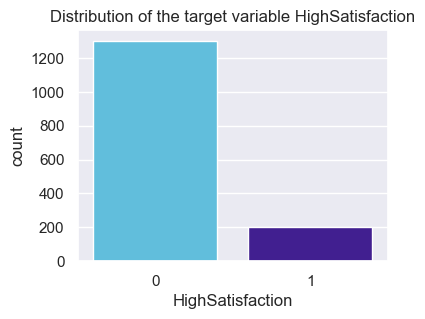

In [10]:
print(df['HighSatisfaction'].value_counts(normalize=True))
plt.figure(figsize=(4, 3))
sns.set_palette(my_palette)
sns.countplot(x=df['HighSatisfaction'])
plt.title('Distribution of the target variable HighSatisfaction')
plt.show()


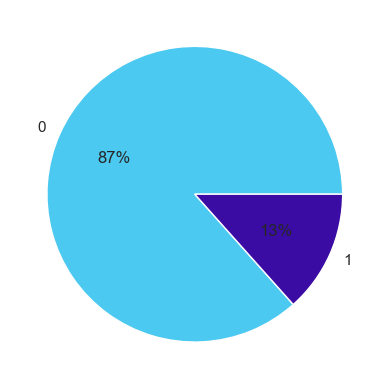

In [11]:
unique, counts = np.unique(df['HighSatisfaction'], return_counts=True)
plt.pie(counts, labels=unique, autopct='%.0f%%');

There is a high imbalance in the dataset based on the target variable.

There's a need for Rebalancing Techniques: In order to improve performance, techniques such as oversampling the minority class (class 1), undersampling the majority class (class 0), or using more advanced approaches like SMOTE (Synthetic Minority Oversampling Technique) might help the model better learn from the minority class.


### Identifying categorical, numerical (nonbinary), and binary columns

In [12]:
numeric_columns = []
for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        unique_val = df[col].nunique()
        if unique_val > 2:
            numeric_columns.append(col)
numeric_columns 

['Age',
 'Income',
 'AverageSpend',
 'GroupSize',
 'WaitTime',
 'ServiceRating',
 'FoodRating',
 'AmbianceRating']

In [13]:
categorical_columns = df.select_dtypes(include=("object")).columns
for col in categorical_columns:
    print(f"{col}: {df[col].unique()}")
categorical_columns = categorical_columns.to_list()

Gender: ['Male' 'Female']
VisitFrequency: ['Weekly' 'Rarely' 'Monthly' 'Daily']
PreferredCuisine: ['Chinese' 'American' 'Indian' 'Mexican' 'Italian']
TimeOfVisit: ['Breakfast' 'Dinner' 'Lunch']
DiningOccasion: ['Business' 'Casual' 'Celebration']
MealType: ['Takeaway' 'Dine-in']


It seems that the rest are binary columns:

In [14]:
binary_columns = ['OnlineReservation', 'DeliveryOrder', 'LoyaltyProgramMember']    

## Analyzing the distributions of all features

### 1. Numerical features

Now we will analyze the distributions of all of the columns.

First, ploting the distributions for numerical features:

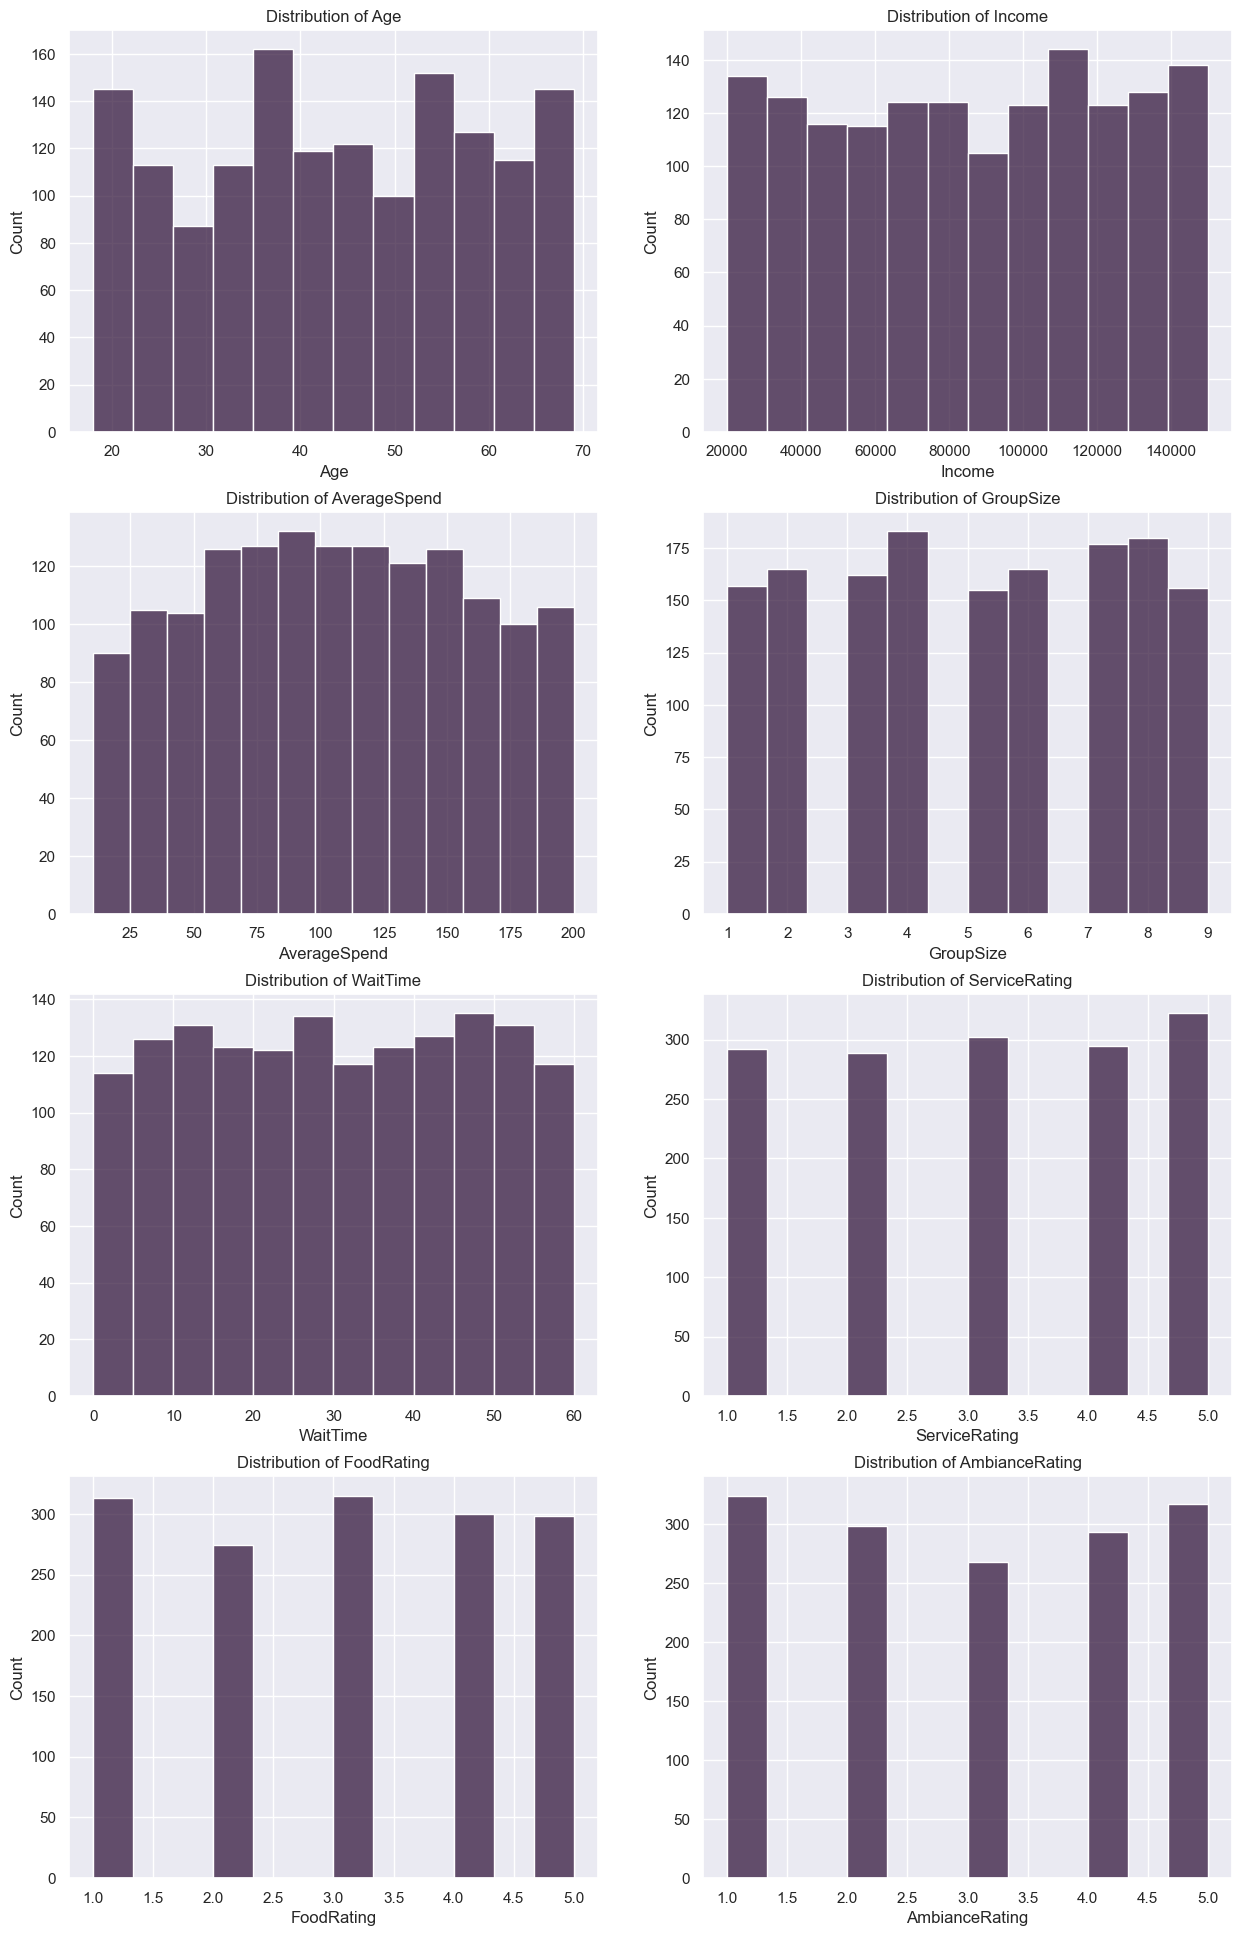

In [15]:
sns.set_palette("rocket")
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 24))
idx_feature = 0
for i in range(ax.shape[0]):
    for j in range(0, ax.shape[1]):
        plot = sns.histplot(df[numeric_columns[idx_feature]],
                     label=numeric_columns[idx_feature],
                     kde=False,
                     #bins=10,
                     ax=ax[i][j])
        plot.set_xlabel(numeric_columns[idx_feature])
        plot.set_title(f'Distribution of {numeric_columns[idx_feature]}')
        idx_feature += 1 
#sns.set_palette("rocket")
#for column in numeric_columns:
#    plt.figure(figsize=(5, 3))
#    sns.histplot(df[column].dropna(), kde=False) #bins=26
#    plt.title(f'Distribution of {column}')
#    plt.show()            

#### Age

It seems that the 'Age' column and most of the other numeric columns mostly have uniform distributions and they don't play a big role for customer satisfaction levels. 

#### Income 

Income Distribution is also Uniform as expected. 

Let's check if the Income column has any effect on AverageSpend since customers with higher income may spend more on average.

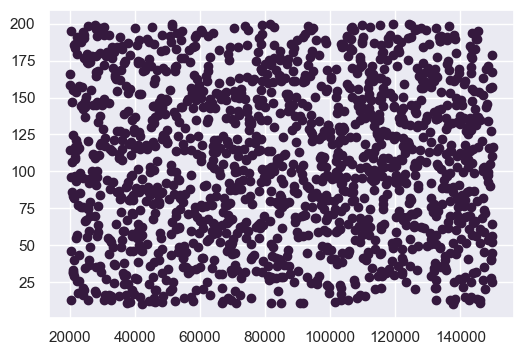

In [16]:
plt.figure(figsize=(6, 4))
fig =plt.scatter(df['Income'], df['AverageSpend'])
fig.title='Income vs Average Spend'
#fix it: title not showing.

It looks like the Income doesnt really matter on the Average Spend column since we can't get any useful Insights looking at the scatter plot.


#### AverageSpend
Next, we check the range of the 'AverageSpend' to find insights about its range and outliers. 



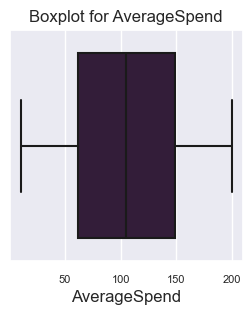

In [17]:
### Check outliers with a box plot
plt.figure(figsize=(3,3))
plt.title('Boxplot for AverageSpend', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
sns.boxplot(x=df['AverageSpend'])  
plt.show()

#### GroupSize

On Average Customers would come in 5 Groups

#### WaitTime
Now analyzing wait time versus customer satisfaction:


In [18]:
unsatisfied_waittime= df[df['HighSatisfaction']==0]['WaitTime'].mean()
satisfied_waittime= df[df['HighSatisfaction']==1]['WaitTime'].mean()
print('Average wait time for satisfied customers is', np.round(satisfied_waittime,2),'minutes.')
print('Average wait time for unsatisfied customers is', np.round(unsatisfied_waittime,2),'minutes.')


Average wait time for satisfied customers is 23.87 minutes.
Average wait time for unsatisfied customers is 31.14 minutes.


Average waiting time of Customers who are satisfied is 23 mins as compared to unsatisfied customers which is above 30 mins.

The wait time is quite long on average which could play a role on the level of satisfaction.

#### ServiceRating, FoodRating, AmbianceRating
Checking all ratings to see if we can find any significant info.

In [19]:
print('Average ServiceRating ', np.round(np.mean(df['ServiceRating']),2))
print('Average FoodRating    ', np.round(np.mean(df['FoodRating']),2))
print('Average AmbianceRating', np.round(np.mean(df['AmbianceRating']),2))
print('\n')
print('Median ServiceRating ', np.round(np.median(df['ServiceRating']),2))
print('Median ServiceRating ', np.round(np.median(df['FoodRating']),2))
print('Median ServiceRating ', np.round(np.median(df['AmbianceRating']),2))
print('\n')
print('Mode ServiceRating  ', np.round(statistics.mode(df['ServiceRating']),2))
print('Mode FoodRating     ', np.round(statistics.mode(df['FoodRating']),2))
print('Mode AmbianceRating ', np.round(statistics.mode(df['AmbianceRating']),2))




Average ServiceRating  3.04
Average FoodRating     3.0
Average AmbianceRating 2.99


Median ServiceRating  3.0
Median ServiceRating  3.0
Median ServiceRating  3.0


Mode ServiceRating   5
Mode FoodRating      3
Mode AmbianceRating  1


The three ratings (ServiceRating, FoodRating, and AmbianceRating) are uniformly distributed,
so there is not much conclusion there. However, when we take the average of the ratings, we see that
they all average around 3. The median and mode also show that the ratings are around 3 and lower. 

Overall Average rating is just 3 stars.

### 2. Categorical features
Distribution of HighSatisfaction over different categorical features:

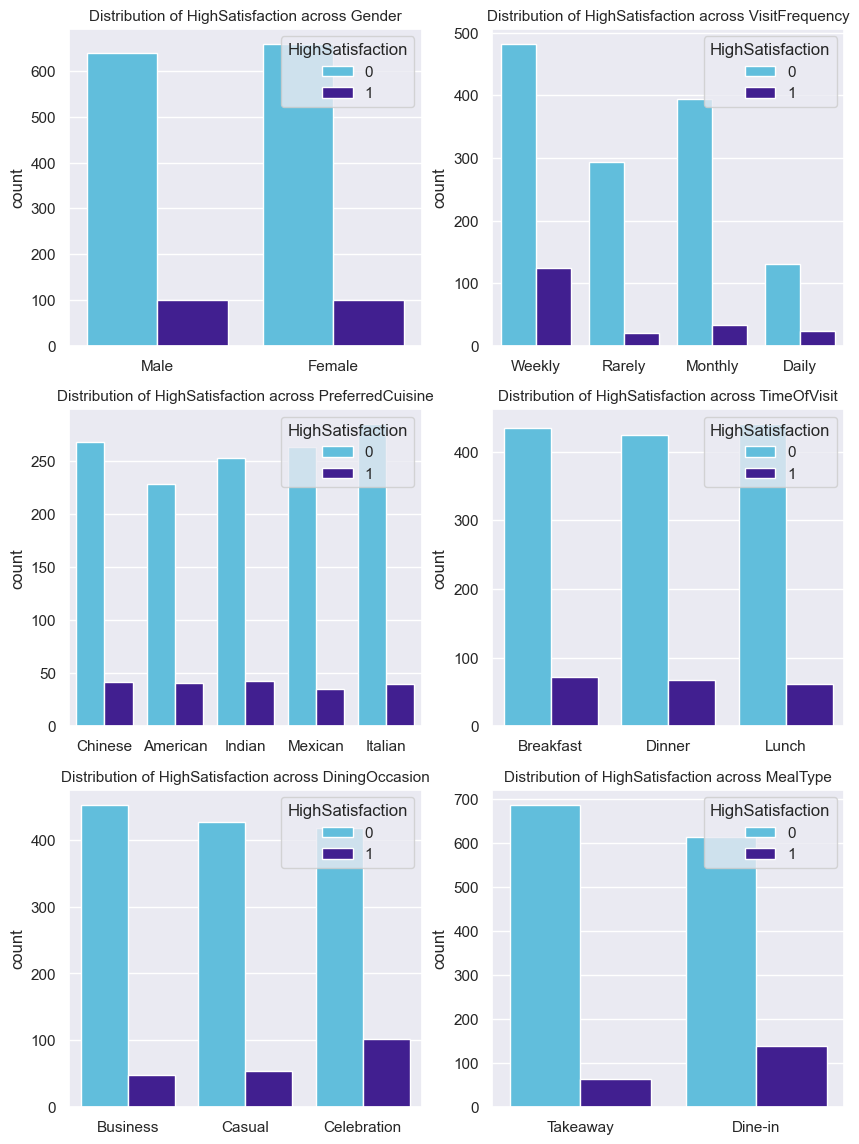

In [20]:
sns.set_palette(my_palette)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 14))
idx_feature = 0
for i in range(ax.shape[0]):
    for j in range(0, ax.shape[1]):
        plot = sns.countplot(x=categorical_columns[idx_feature], hue='HighSatisfaction', data=df,
                     #label=categorical_columns[idx_feature],
                     #kde=False,
                     ax=ax[i][j])
        plot.set(xlabel=None)
        #plot.legend(fontsize='small', title_fontsize='10')
        #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),fontsize=10)
        #plot.set_xlabel(categorical_columns[idx_feature])
        plot.set_title(f'Distribution of HighSatisfaction across {categorical_columns[idx_feature]}',fontsize=11)
        idx_feature += 1 
        
#for column in categorical_columns:
#    plt.figure(figsize=(5, 2))
#    ax = sns.countplot(x=column, hue='HighSatisfaction', data=df)
#    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#    plt.title(f'Distribution of HighSatisfaction across {column}')
#    plt.show()

####  Gender

From the above chart, we can conclude that the Gender column doesn't really play a big role in the satisfaction level.

Checking the overall gender distribution:

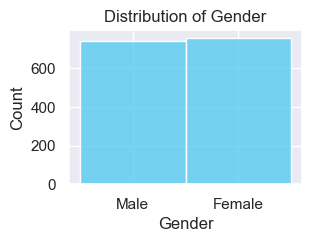

In [21]:
#sns.set_palette(my_palette)
plt.figure(figsize=(3, 2))
sns.histplot(df['Gender'].dropna(), kde=False) #bins=26
plt.title(f'Distribution of Gender')
plt.show()

#### VisitFrequency

To observe visit frequency better, calculate the count of each visit frequency:

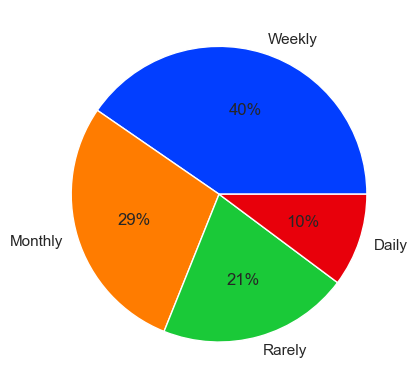

In [22]:
visit_counts = df['VisitFrequency'].value_counts()
palette_color = sns.color_palette('bright') 
plt.pie(x = visit_counts, labels=visit_counts.index, colors=palette_color, autopct='%.0f%%') 
plt.show() 

From the pie chart, we observe that 40% of the customers visit Weekly while only 10% visit daily. Nearly 30% customers visit only Monthly and more than 20% of the customers rarely even visit the restaurant.

The pie chart helps to show that about 50% of of the visits are weekly and daily, and the other 50% of the visits are monthly and rarely. Looking at the countplot above for VisitFrequency, we observe that other than weekly visits, the rest of the visits show much lower satisfaction levels. Even with weekly visits, most of the customers are unsatisfied. So in addition to other features, from the VisitFrequency feature we can also conclude that the restaurant is performing poorly overall. The visit frequency indicates that most of the customers are not satisfied with the restaurant regardless of their frequency of visit. 

#### PreferredCuisine

Looking at PreferredCuisine, customers prefer Italian more but they are almost equal so we can't conclude much. The cuisine doesn't seem to play a big role in customer satisfaction.

#### TimeOfVisit

All 3 TimeOfVisits are uniform, so it does not play much role in the satisfaction level. As mentioned above, there are some distinction between the number of customers for different times of the day and different dining occasions. Most customers visit for Breakfast on Business Occasions. Most customers who come for celebration visit on Lunch times. Most customers who come casually to the restaurant visit for dinner.


#### DiningOccasion vs. TimeOfVisit

We can check DiningOccasion vs. TimeOfVisit to see if we can get any more insights.

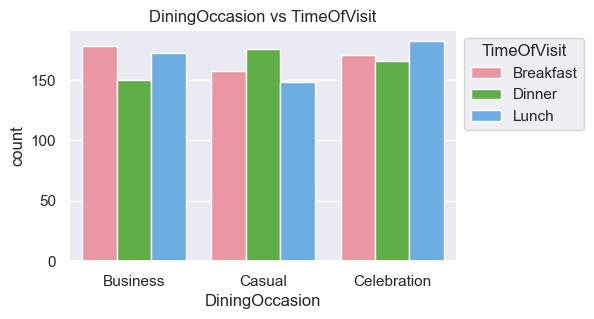

In [23]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='DiningOccasion', hue='TimeOfVisit', data=df)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('DiningOccasion vs TimeOfVisit')
plt.show()

Checking DiningOccasion versus TimeOfVisit, we can conclude that:

- Most customers visit for Breakfast on a business occasion.
- Most customers who come casually visit for dinner.
- Most customers, who come for a celebration, visit on lunch.

#### MealType:

We can see that the customers who are satisfied prefer to dine in, however customers who aren't satisfied prefer takeaway (slightly more than dining in). 

### 3. Binary (numerical) features

Now looking at the binary columns:

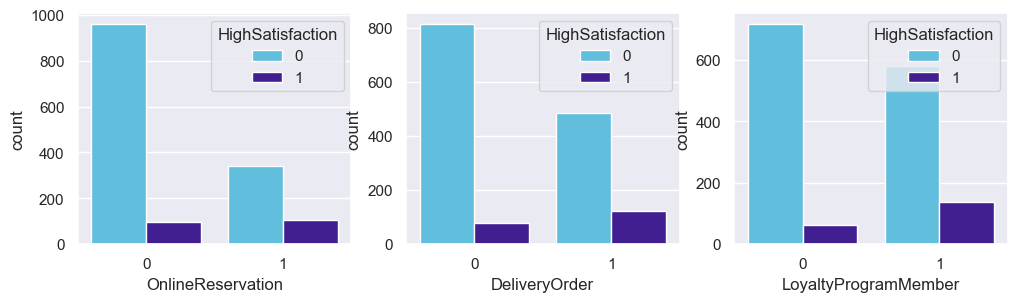

In [24]:
sns.set_palette(my_palette)
plt.figure(figsize=(12, 3)) 
idx_feature = 0
for i in range(len(binary_columns)):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=binary_columns[idx_feature], hue='HighSatisfaction', data=df)
    plot.set_title(f'Distribution of HighSatisfaction across {binary_columns[idx_feature]}',fontsize=11)
    idx_feature += 1 
    
#plt.figure(figsize=(5, 2))
#ax = sns.countplot(x=df['OnlineReservation'], hue='HighSatisfaction', data=df)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.title(f'Distribution of HighSatisfaction across OnlineReservation')
#plt.show()

#### OnlineReservation
For OnlineReservation, most of the unsatisfied customers did not make online reservations. 

#### DeliveryOrder
Most of the orders were not for delivery and the majority of those cusomers with no delivery were unsatisfied. The minority of customers who ordered delivery were slightly more satisfied.

#### LoyaltyProgramMember
Customers who are LoyaltyProgramMember are likely to be Satisfied, but majority of them are not LoyaltyProgramMember.

# Feature Engineering

No Data Cleaning is required because there are no duplicates, null values, outliers, or any wrong formats in the dataset. The dataset is clean. 

There is no need to do Data Preprocessing because there are 6 nominal categorical Variables (categorical_columns) that need to be encoded. And there are 3 non binary numerical variables (numeric_columns) that need to be scaled.

#### Income_Per_Age 

Creating one new feature Income_Per_Age and adding it to the numeric_columns list

In [25]:
df['Income_Per_Age'] = df['Income'] / df['Age']

In [26]:
numeric_columns.extend(['Income_Per_Age']) 

In [27]:
# checking correlations: Move to after encoding?
#plt.figure(figsize=(15,15))
#sns.heatmap(df.astype(float).corr(),linewidths=0.1, vmax=1.0, 
#            square=True,  linecolor='white', annot=True)
#plt.show()

## Split the data

We define the X (predictor) and y (target) variables. Split into train and test sets (using stratify because of the imbalanced dataset. We will preserve this ratio when we model.)

We split the data before encoding and scaling the features to avoid data leakage.

In [28]:
y = df["HighSatisfaction"]
X = df.drop("HighSatisfaction", axis = 1)

# Encode the target variable. Not really needed because it's already binary.
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_

array([0, 1])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=rs)

Using StratifiedShuffleSplit

In [30]:
'''
feature_cols  = [x for x in df.columns if x not in 'HighSatisfaction'] #or feature_cols = X.columns

# Split the data into two parts with a specific number of points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=int(len(X)/5), random_state=rs)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(X, y))

# Create the data sets
X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, 'HighSatisfaction']

X_test = df.loc[test_idx, feature_cols]
y_test = df.loc[test_idx, 'HighSatisfaction']
'''

"\nfeature_cols  = [x for x in df.columns if x not in 'HighSatisfaction'] #or feature_cols = X.columns\n\n# Split the data into two parts with a specific number of points in the test data\n# This creates a generator\nstrat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=int(len(X)/5), random_state=rs)\n\n# Get the index values from the generator\ntrain_idx, test_idx = next(strat_shuff_split.split(X, y))\n\n# Create the data sets\nX_train = df.loc[train_idx, feature_cols]\ny_train = df.loc[train_idx, 'HighSatisfaction']\n\nX_test = df.loc[test_idx, feature_cols]\ny_test = df.loc[test_idx, 'HighSatisfaction']\n"

## Encoding

We use OneHotEncoder for the categorical_columns and MinMaxScaler() or StandardScaler() for the (nonbinary) numeric_columns. We use the make_column_transformer() passing in the two encoder objects "ohe" and "minmax" or "stdscaler". We are using remainder='passthrough' so that it will pass through the rest of the columns without transforming them (what we have left are binary_columns features already).

Note: setting verbose_feature_names_out to False stops the ColumnTransformer from adding the encoder name as a prefix.

In [31]:
ohe = OneHotEncoder(categories = 'auto', sparse_output=False)
minmax = MinMaxScaler()  
stdscaler = StandardScaler() 
transformer = make_column_transformer(
    (ohe, categorical_columns),
    (minmax, numeric_columns),
    remainder='passthrough',
    verbose_feature_names_out=False) 

In [32]:
transformer.set_output(transform = "pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['Gender', 'VisitFrequency',
                                  'PreferredCuisine', 'TimeOfVisit',
                                  'DiningOccasion', 'MealType']),
                                ('minmaxscaler', MinMaxScaler(),
                                 ['Age', 'Income', 'AverageSpend', 'GroupSize',
                                  'WaitTime', 'ServiceRating', 'FoodRating',
                                  'AmbianceRating', 'Income_Per_Age'])],
                  verbose_feature_names_out=False)

We want to get a DataFrame as output. There are two ways for doing that. 

1. use x = transformer.fit_transform(X_train) 

Another way to get a DataFrame as output:

2. use transformer.get_feature_names_out()

Then, can check if they're equal: x.equals(transformed_X_train)

In [33]:
transformed_X_train = transformer.fit_transform(X_train)
transformed_X_train = pd.DataFrame(transformed_X_train
                                   ,columns=transformer.get_feature_names_out()
                                   ,index=X_train.index)

transformed_X_test = transformer.transform(X_test)
transformed_X_test = pd.DataFrame(transformed_X_test
                                   ,columns=transformer.get_feature_names_out()
                                   ,index = X_test.index)

Replacing X_train and X_test back with the transformed versions.

In [34]:
X_train = transformed_X_train.copy()
X_test  = transformed_X_test.copy()

## SMOTE

In [35]:
## Apply SMOTE to the training set (if needed)
#smote = SMOTE(random_state=rs)
#X_res, y_res = smote.fit_resample(X_train, y_train)

#X_train = X_res.copy()
#y_train = y_res.copy()
#len(X_train),len(X_test)

This following function will calculate the accuracy of the training and testing data given a model.

In [36]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train)),
             "test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test))
             }


Here is a utility method to evaluate the trained models and output some standard evaluation metrics.

In [37]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [38]:
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

#create. a func:
#train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
#                                   measure_error(y_test,  y_test_pred, 'test')],
#                                   axis=1)

#train_test_full_error


In [39]:
def print_confusion_matrix(y_test, y_pred):
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    return plt

# Confusion matrix
# cm = metrics.confusion_matrix(y_test, y_pred)
# disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_gbc.classes_)
# disp.plot()

We will use the Imbalanced-learn library (imblearn) from sklearn to improve the performance of imbalanced sets. The parameter added is class_weight="balanced".

There are other ways to improve the performance of the models with imbalanced datasets, such as random under-sampling and using a balanced bagging classifier from imblearn.ensemble.

# Classifers

## 1. Decision Trees

We start by running a default decision tree classifier. We define the DecisionTreeClassifier object and use the default arguments. Then we can train the decision tree model with training data and make predictions on the test data. Then checking accuracy and other metrics. And finally plot the decision tree model with tree.plot_tree() from sklearn.

#### Base tree:

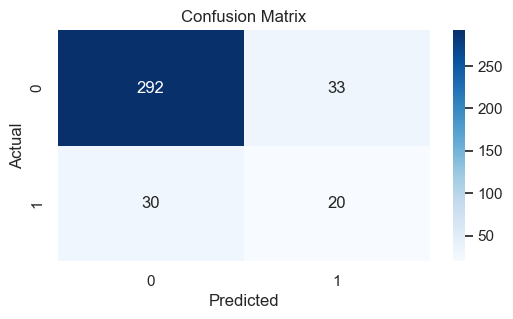

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       325
           1       0.38      0.40      0.39        50

    accuracy                           0.83       375
   macro avg       0.64      0.65      0.65       375
weighted avg       0.84      0.83      0.83       375

{'train Accuracy': 1.0, 'test Accuracy': 0.832}

test accuracy:
[0.0129835  0.00023657 0.01948055 0.01485772 0.00663663 0.04468579
 0.0154032  0.00182444 0.01352149 0.01042408 0.00195249 0.00199164
 0.         0.00517961 0.00303497 0.00176959 0.02350338 0.00980878
 0.00533333 0.03915862 0.08596087 0.14606664 0.07533273 0.11534392
 0.03148118 0.09192734 0.03312911 0.06172274 0.04593937 0.0599679
 0.02134183]
319 18
[0.0129835  0.00023657 0.01948055 0.01485772 0.00663663 0.04468579
 0.0154032  0.00182444 0.01352149 0.01042408 0.00195249 0.00199164
 0.         0.00517961 0.00303497 0.00176959 0.02350338 0.00980878
 0.00533333 0.03915862 0.08596087 0.14606664 0.0753327

{'accuracy': 0.832,
 'recall': 0.4,
 'precision': 0.37735849056603776,
 'f1score': 0.38834951456310685}

In [40]:
model_dt = DecisionTreeClassifier(random_state=rs,class_weight="balanced")
model_dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_test)
print_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(get_accuracy(X_train, X_test, y_train, y_test, model_dt))
print("\ntest accuracy:")

print(model_dt.feature_importances_)
print(model_dt.tree_.node_count, model_dt.tree_.max_depth)

evaluate_metrics(y_test, y_pred)

Since class 1 (positive class) is relatively rare (~13%), it is harder for the model to correctly predict positive instances. Precision means that of all the positive predictions made by the model, only that percentage are actually true positives. The model is likely over-predicting positives, resulting in a high number of false positives.


Recall means the model is only identifying some percentage of the actual positive cases, which is low. This suggests that the model is missing many positive cases (i.e., high false negatives). Given that only ~13% of the data belongs to class 1, this suggests the model is failing to identify many true positives. Many actual class 1 instances are being missed, resulting in a high false negative rate.


The model’s performance on the minority class (class 1) is poor, and the class imbalance is likely contributing significantly to this. Without addressing the imbalance, it will be hard to improve the precision and recall meaningfully.


Some insights:

High False Positive Rate: With a low precision, a large portion of the positive predictions made by the model are wrong. This could lead to costly or undesirable actions if positive predictions are tied to significant consequences.


Low True Positive Coverage: The recall of 0.n shows that the model is missing a large portion of true positives. So, while it makes many positive predictions (with low accuracy), it also fails to capture most of the actual positives.

Trade-off Between Precision and Recall: There seems to be a trade-off between precision and recall. If improving one, you'll likely worsen the other unless changes to the model or data can improve overall performance.

In summary, the model's positive predictions are unreliable both in terms of missing many true positives and including many false positives, and further tuning or adjustments to the model may be necessary.



Let's try a custom DT model and see if it improves the performance:

#### Custom tree with some constraints:

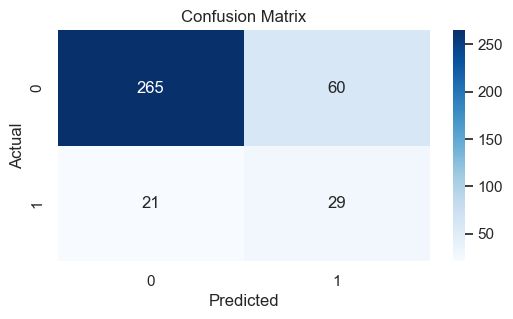

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       325
           1       0.33      0.58      0.42        50

    accuracy                           0.78       375
   macro avg       0.63      0.70      0.64       375
weighted avg       0.85      0.78      0.81       375

{'train Accuracy': 0.8808888888888889, 'test Accuracy': 0.784}

test accuracy:


{'accuracy': 0.784,
 'recall': 0.58,
 'precision': 0.3258426966292135,
 'f1score': 0.4172661870503597}

In [41]:
custom_model_dt= DecisionTreeClassifier(criterion='entropy',
                                        max_depth=8,
                                        min_samples_leaf=5,
                                        random_state=rs,
                                        class_weight="balanced")
custom_model_dt.fit(X_train, y_train)
y_pred = custom_model_dt.predict(X_test)
print_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(get_accuracy(X_train, X_test, y_train, y_test, custom_model_dt))
print("\ntest accuracy:")
evaluate_metrics(y_test, y_pred)

Let's use grid search cross validation to improve the performance.

#### Decision Tree with gridsearch cross validation:

Now we use grid search CV to see if we can improve the performance:

In [42]:
param_grid = {'max_depth': [4,6,8,10], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [5, 10, 15, 20]}
scoring = {'accuracy', 'precision', 'recall', 'f1'}
gridsearchcv_dt = GridSearchCV(DecisionTreeClassifier(random_state=rs,class_weight="balanced"),
                  param_grid=param_grid,
                  scoring=scoring,
                  n_jobs=-1,
                  refit='recall')
                  #error_score='raise')
#param_grid = {'max_depth':range(4, custom_model_dt.tree_.max_depth+1,2),
#              'max_features': range(4, len(custom_model_dt.feature_importances_)+1)} #'max_features':["auto", "sqrt", "log2"]}

In [43]:
%%time
gridsearchcv_dt = gridsearchcv_dt.fit(X_train, y_train)
gridsearchcv_dt.best_estimator_.tree_.node_count, gridsearchcv_dt.best_estimator_.tree_.max_depth


CPU times: user 557 ms, sys: 135 ms, total: 692 ms
Wall time: 7.81 s


(29, 4)

Pickle the model. Comment out when done.
Then read the saved pickled model.

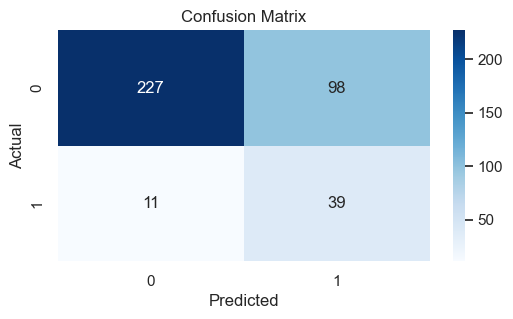

{'max_depth': 4, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.95      0.70      0.81       325
           1       0.28      0.78      0.42        50

    accuracy                           0.71       375
   macro avg       0.62      0.74      0.61       375
weighted avg       0.86      0.71      0.75       375

{'train Accuracy': 0.712, 'test Accuracy': 0.7093333333333334}

test accuracy:


{'accuracy': 0.7093333333333334,
 'recall': 0.78,
 'precision': 0.2846715328467153,
 'f1score': 0.4171122994652406}

In [44]:
with open('gridsearchcv_dt.pickle', 'wb') as to_write:
    pickle.dump(gridsearchcv_dt, to_write)
with open('gridsearchcv_dt.pickle', 'rb') as to_read:
    gridsearchcv_dt = pickle.load(to_read)
y_pred = gridsearchcv_dt.predict(X_test)
print_confusion_matrix(y_test, y_pred)
print(gridsearchcv_dt.best_params_)
print(classification_report(y_test, y_pred))
print(get_accuracy(X_train, X_test, y_train, y_test, gridsearchcv_dt))
print("\ntest accuracy:")
evaluate_metrics(y_test, y_pred)

Plotting the trees if needed: 

In [45]:
def plot_decision_tree(model, feature_names):
    plt.subplots(figsize=(25, 20)) 
    tree.plot_tree(model, 
                       feature_names=feature_names,  
                       filled=True)
    plt.show()
    
feature_names = X_train.columns.values
#plot_decision_tree(gridsearchcv_dt.best_estimator_, feature_names)

It seems that the decision tree cannot improve the recall and precision scores. So moving on to other classifiers. 

## 2. RandomForestClassifier

#### Base Random Forest

First we can try the base estimator, and then try a grid search cross validation.

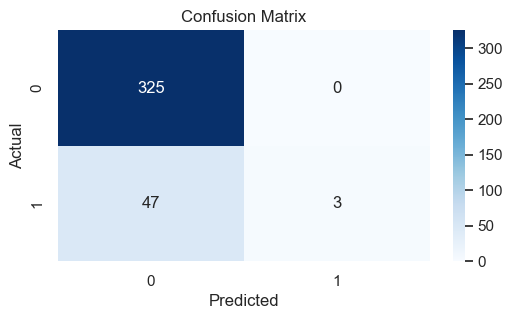

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       325
           1       1.00      0.06      0.11        50

    accuracy                           0.87       375
   macro avg       0.94      0.53      0.52       375
weighted avg       0.89      0.87      0.82       375

{'train Accuracy': 1.0, 'test Accuracy': 0.8746666666666667}

test accuracy:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_w

In [46]:
model_rf = RandomForestClassifier(random_state=rs,class_weight="balanced")
model_rf.fit(X_train,y_train)
y_pred = model_rf.predict(X_test)
print_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(get_accuracy(X_train, X_test, y_train, y_test, model_rf))
print("\ntest accuracy:")
evaluate_metrics(y_test, y_pred)
#print(model_rf.get_params())
#print(model_rf.get_params().keys())

Precision - recall balance: If precision is high, it means that out of all predicted positives, most of them were predicted correctly, but considering a low recall, the positives that were correctly predicted were low. We will check for grid search cross validation. 

#### Random Forest with gridsearch cross validation:
We use GridSearchCV to find the best parameters.

In [47]:
param_grid = {'max_depth': [4,6,8,10], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [5, 10, 15, 20],
             'n_estimators': [75, 100, 125, 150]}
scoring = {'accuracy', 'precision', 'recall', 'f1'}
gridsearchcv_rf = GridSearchCV(estimator=model_rf,
                               param_grid=param_grid,
                               scoring=scoring,
                               cv=5,
                               refit='recall', 
                               error_score='raise')
#param_grid = {'max_depth': [2,3,4,5], 
#             'min_samples_leaf': [1,2,3],
#             'min_samples_split': [2,3,4],
#             'max_features': [5, 10, 15, 20],
#             'n_estimators': [75, 100, 125, 150]
#             }  
#param_grid = {'n_estimators': [2*n+1 for n in range(20)],
#             'max_depth' : [2*n+1 for n in range(10) ],
#             'max_features':["auto", "sqrt", "log2"]}

In [48]:
%%time
#It takes about 14 minutes to run
gridsearchcv_rf.fit(X_train, y_train)

#To get the best_params_, need the tree, not the GridSearchCV object. 
#best_model = rf_cv.best_estimator_
#best_model.fit(X_train, y_train)

CPU times: user 14min 35s, sys: 9.25 s, total: 14min 44s
Wall time: 15min 3s


GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'max_features': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='recall', scoring={'precision', 'f1', 'accuracy', 'recall'})

We pickle the fitted model and comment out the fitting cell when done. Then read the saved pickled model.

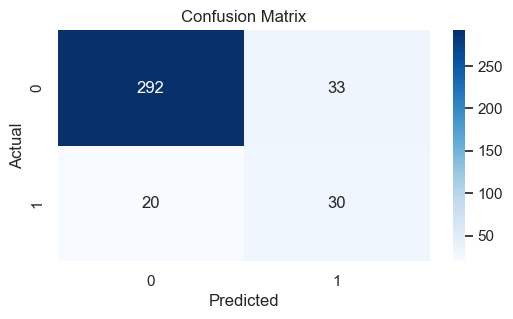

{'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       325
           1       0.48      0.60      0.53        50

    accuracy                           0.86       375
   macro avg       0.71      0.75      0.72       375
weighted avg       0.87      0.86      0.87       375

{'train Accuracy': 0.9173333333333333, 'test Accuracy': 0.8586666666666667}

test accuracy:


{'accuracy': 0.8586666666666667,
 'recall': 0.6,
 'precision': 0.47619047619047616,
 'f1score': 0.5309734513274337}

In [49]:
with open('gridsearchcv_rf.pickle', 'wb') as to_write:
    pickle.dump(gridsearchcv_rf, to_write)
with open('gridsearchcv_rf.pickle', 'rb') as to_read:
    gridsearchcv_rf = pickle.load(to_read)    
y_pred = gridsearchcv_rf.predict(X_test)
#y_pred = best_model.predict(X_test)
print_confusion_matrix(y_test, y_pred)
print(gridsearchcv_rf.best_params_)
print(classification_report(y_test, y_pred))
print(get_accuracy(X_train, X_test, y_train, y_test, gridsearchcv_rf))
print("\ntest accuracy:")
evaluate_metrics(y_test, y_pred)    

## 3. GradientBoostingClassifier from sklearn

Note: GB doesn't allow class_weight. 
Error: TypeError: GradientBoostingClassifier.__init__() got an unexpected keyword argument 'class_weight'


#### Base Gradient Boosting Classifier:

In [50]:
model_gbc=GradientBoostingClassifier(random_state=rs)

#### Custom Gradient Boosting Classifier with some constraints:

In [51]:
custom_model_gbc=GradientBoostingClassifier(n_estimators=500,
                                            learning_rate=0.05,
                                            random_state=rs,
                                            max_features=5)

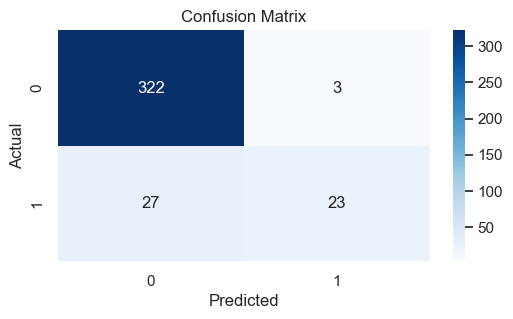

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       325
           1       0.88      0.46      0.61        50

    accuracy                           0.92       375
   macro avg       0.90      0.73      0.78       375
weighted avg       0.92      0.92      0.91       375

{'train Accuracy': 0.9795555555555555, 'test Accuracy': 0.92}

test accuracy:


{'accuracy': 0.92,
 'recall': 0.46,
 'precision': 0.8846153846153846,
 'f1score': 0.605263157894737}

In [52]:
custom_model_gbc.fit(X_train,y_train)
y_pred = custom_model_gbc.predict(X_test)
print_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(get_accuracy(X_train, X_test, y_train, y_test, custom_model_gbc))
print("\ntest accuracy:")
evaluate_metrics(y_test, y_pred) 
#roc_auc = roc_auc_score(y_test, y_pred)
#roc_auc

#### Gradient Boosting Classifier with gridsearch cross validation:

In [53]:
param_grid = {'learning_rate': [0.3],
             'max_depth': [6],
             'n_estimators': [500],
             'subsample': [0.7]}
scoring = {'accuracy', 'precision', 'recall', 'f1'}
gridsearchcv_gbc = GridSearchCV(model_gbc,
                      param_grid,
                      scoring = scoring,
                      cv = 5,
                      refit = 'recall')

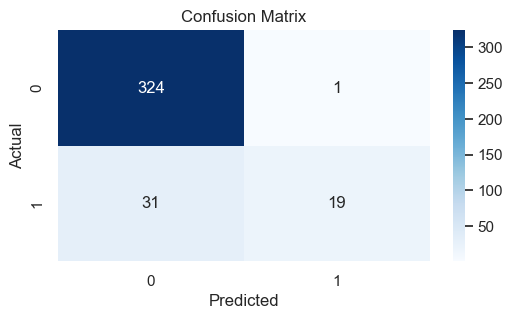

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.7}
0.2651612903225806
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       325
           1       0.95      0.38      0.54        50

    accuracy                           0.91       375
   macro avg       0.93      0.69      0.75       375
weighted avg       0.92      0.91      0.90       375

{'train Accuracy': 1.0, 'test Accuracy': 0.9146666666666666}

test accuracy:


{'accuracy': 0.9146666666666666,
 'recall': 0.38,
 'precision': 0.95,
 'f1score': 0.5428571428571428}

In [54]:
gridsearchcv_gbc.fit(X_train, y_train)
with open('gridsearchcv_gbc.pickle', 'wb') as to_write:
    pickle.dump(gridsearchcv_gbc, to_write)
with open('gridsearchcv_gbc.pickle', 'rb') as to_read:
    gridsearchcv_gbc = pickle.load(to_read) 
y_pred = gridsearchcv_gbc.predict(X_test)
print_confusion_matrix(y_test, y_pred)
print(gridsearchcv_gbc.best_params_)
print(gridsearchcv_gbc.best_score_)
print(classification_report(y_test, y_pred))
print(get_accuracy(X_train, X_test, y_train, y_test, gridsearchcv_gbc))
print("\ntest accuracy:")
evaluate_metrics(y_test, y_pred) 


## 4. XGBoost 

#### XGBoost with gridsearch cv:

We will use GridSearchCV. Define parameters for tuning.

In [55]:
model_xgb = XGBClassifier(objective='binary:logistic', random_state=rs,class_weight="balanced")
param_grid = {'max_depth': [6,8,10],
              'min_child_weight': [3, 5],
              'learning_rate': [0.05,0.1, 0.2, 0.3],
              'n_estimators': [100,300,500],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'max_features':[5]
              }
scoring = {'accuracy', 'precision', 'recall', 'f1'}
gridsearchcv_xgb = GridSearchCV(model_xgb,
                      param_grid,
                      scoring = scoring,
                      cv = 5,
                      refit = 'recall',
                      error_score='raise')

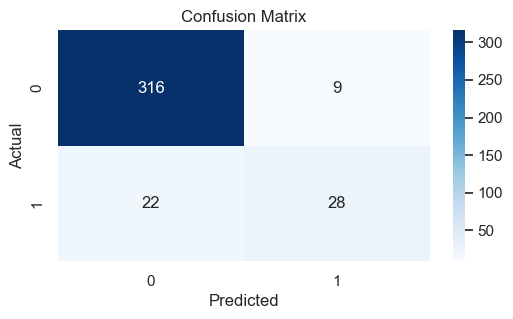

{'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 6, 'max_features': 5, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.7}
0.43053763440860215
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       325
           1       0.76      0.56      0.64        50

    accuracy                           0.92       375
   macro avg       0.85      0.77      0.80       375
weighted avg       0.91      0.92      0.91       375

{'train Accuracy': 0.9973333333333333, 'test Accuracy': 0.9173333333333333}

test accuracy:


{'accuracy': 0.9173333333333333,
 'recall': 0.56,
 'precision': 0.7567567567567568,
 'f1score': 0.6436781609195402}

In [56]:
gridsearchcv_xgb.fit(X_train, y_train)
with open('gridsearchcv_xgb.pickle', 'wb') as to_write:
    pickle.dump(gridsearchcv_xgb, to_write)
with open('gridsearchcv_xgb.pickle', 'rb') as to_read:
    gridsearchcv_xgb = pickle.load(to_read)    
y_pred = gridsearchcv_xgb.predict(X_test)
print_confusion_matrix(y_test, y_pred)
print(gridsearchcv_xgb.best_params_)
print(gridsearchcv_xgb.best_score_)
print(classification_report(y_test, y_pred))
print(get_accuracy(X_train, X_test, y_train, y_test, gridsearchcv_xgb))
print("\ntest accuracy:")
evaluate_metrics(y_test, y_pred) 

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

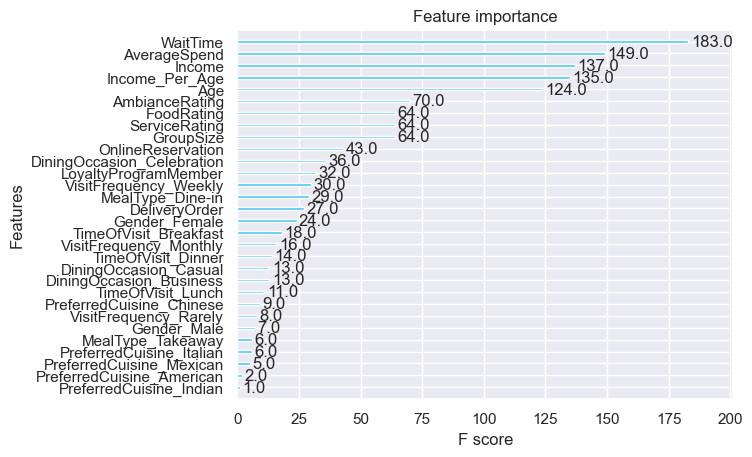

In [57]:
plot_importance(gridsearchcv_xgb.best_estimator_)

### Comparing the models with cross_validate:

Now, as an alternative validation process, we will examine the above models using the cross_validate method in sklearn.model_selection. This will take some time to run, but we will get all the models listed with their respective test evaluation metrics. If we want, we can add the eval metrics for the training set to the scores list/dataframe too by adding a variable in the cross_validate parameters list.
The Gradient Boosting Classifier does not have the class_weight="balanced" param option to be added to the classifier object. 

In order to compare the models, we keep their index and scores to put into a table.


In [58]:
index = []
scores = {"Accuracy":[],"Balanced accuracy":[],"Recall":[],"Precision":[],"f1":[],}

In [59]:
def scores_dataframe(index,model):
    scoring = ["accuracy", "balanced_accuracy","recall","precision","f1"]  
    cv_result = cross_validate(model, X_train, y_train, scoring=scoring)

    scores["Accuracy"].append(cv_result["test_accuracy"].mean())
    scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
    scores["Recall"].append(cv_result["test_recall"].mean())
    scores["Precision"].append(cv_result["test_precision"].mean())
    scores["f1"].append(cv_result["test_f1"].mean())
    df_scores = pd.DataFrame(scores, index=index)
    return df_scores

In [ ]:
#With cross_validate, if we want, we can add the eval metrics for the training set to the scores too. 
#Need to add a variable in the cross_validate params and add to scores list. 
 
index += ["Balanced Decision Tree classifier-Base"]
scores_dataframe(index,model_dt)

index += ["Balanced Decision Tree classifier-Custom"]
scores_dataframe(index,custom_model_dt)

index += ["Balanced Decision Tree classifier-GridSearchCV"]
scores_dataframe(index,gridsearchcv_dt)

index += ["Balanced Random Forest Classifier-Base"]
scores_dataframe(index,model_rf)

index += ["Balanced Random Forest classifier-GridSearchCV"]
scores_dataframe(index,gridsearchcv_rf)

index += ["Gradient Boosting Classifier-Base"]
scores_dataframe(index,model_gbc)

index += ["Gradient Boosting Classifier-Custom"]
scores_dataframe(index,custom_model_gbc)

index += ["Gradient Boosting Classifier-GridSearchCV"]
scores_dataframe(index,gridsearchcv_gbc)

index += ["Balanced XGBoost classifier-GridSearchCV"]
table = scores_dataframe(index,gridsearchcv_xgb)


In [ ]:
table

### To Do: 

1. try StandardScaler() later instead of minmax. 
2. Use SMOTE
3. Put all the models in a pipeline
4. Classify using other models (SVM, KNN, Logistic Reg, ANN, etc.)
5. Try other methods to overcome unbalanced data issue: random under-sampling and balanced bagging classifier